# Learning models and meta model with TimeSeriesSplit
### kolla artiklar om stacking, cv för stacking samt cv för stacking av timeseries 
- https://machinelearningmastery.com/implementing-stacking-scratch-python/   (Även kod i Pieces)  
Även allmänt om stacking ensembles  
- https://machinelearningmastery.com/essence-of-stacking-ensembles-for-machine-learning/  
Slutligen CV för Timeseries stacking  (se kod i Pieces)  
- https://datascience.stackexchange.com/questions/41378/how-to-apply-stacking-cross-validation-for-time-series-data

Beskrivning:  
- gör webscrape av omgång(ar) i omg_att_spela_link.csv
- concat nya_lopp med all_data och spara
- Lägg undan validate (V) för meta-modellen (20% av all_data)
- tscv = TimeSeriesSplit(n_splits=5) för all_data
- for splits 1-5 learn all previous split and predict next split concatenatate stepwise this will create one predict series for each model  
- create a stack with models predictions and learn meta model
- Final train on models with all data except the V
- predict on V, build stack and test the meta model
- finally learn meta model on p1-p5 plus V
 


# Generella funktioner

In [1]:
# moduler
from sklearn.ensemble import RandomForestRegressor
import sys
import pandas as pd
import numpy as np
import pickle
from catboost import CatBoostClassifier, Pool, cv
from IPython.display import display
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', 200)
from sklearn.model_selection import TimeSeriesSplit

sys.path.append(
    'C:\\Users\\peter\\Documents\\MyProjects\\PyProj\\Trav\\spel\\')

# sys.path.append('C:\\Users\\peter\\Documents\\MyProjects\\PyProj\\Trav\\spel\\modeller\\')
import V75_scraping as vs

import typ as tp

pref = '../'

END


Web scraping

In [2]:
def v75_scraping():
    df, strukna = vs.v75_scraping(history=True, resultat=True, headless=True)
    
    for f in ['häst','bana', 'kusk', 'h1_kusk', 'h2_kusk', 'h3_kusk', 'h4_kusk', 'h5_kusk', 'h1_bana', 'h2_bana', 'h3_bana', 'h4_bana', 'h5_bana']:
        df[f] = df[f].str.lower()
    return df

# v75_scraping()

Preparera data

In [3]:
def remove_features(df_, remove_mer=[]):
    df = df_.copy()
    df.drop(['startnr', 'vodds', 'podds', 'bins', 'h1_dat',
             'h2_dat', 'h3_dat', 'h4_dat', 'h5_dat'], axis=1, inplace=True)
    if remove_mer:
        df.drop(remove_mer, axis=1, inplace=True)

    return df

In [4]:

# Förbered för learning
def förbered(df,meta_procent):
    # Följande datum saknar avd==5 och kan inte användas
    saknas = ['2015-08-15', '2016-08-13', '2017-08-12']
    df = df[~df.datum.isin(saknas)]
    X = df.copy()
    X.drop('plac', axis=1, inplace=True)
    
    # läs in FEATURES.txt
    with open(pref+'FEATURES.txt', 'r',encoding='utf-8') as f:    
        features = f.read().splitlines()
     
    X=X[features]
    
    assert len(features) == len(X.columns), f'features {len(features)} and X.columns {len(X.columns)} are not the same length'   
    assert set(features) == set(X.columns), f'features {set(features)} and X.columns {set(X.columns)} are not the same'
    
    # X=remove_features(X)
    
    y = (df.plac == 1)*1   # plac 1 eller 0

    for f in ['häst', 'bana', 'kusk', 'h1_kusk', 'h2_kusk', 'h3_kusk', 'h4_kusk', 'h5_kusk', 'h1_bana', 'h2_bana', 'h3_bana', 'h4_bana', 'h5_bana']:
        X[f] = X[f].str.lower()

    X.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)
   
    meta_antal = int(len(X.datum.unique())*meta_procent)
    meta_datum = X.datum.unique()[-meta_antal:]
    X_val = X.loc[X.datum.isin(meta_datum)]
    y_val = y[X_val.index]
    X=X.loc[~X.datum.isin(meta_datum)]
    y=y.loc[X.index]
    
    return X, y, X_val, y_val


In [5]:
# modellerna
#              namn, ant_hästar, proba, Kelly,  motst_ant, motst_diff, ant_favoriter,   only_clear, streck
typ6 = tp.Typ('typ6', True,       True, False,     0,       False,          0,            False,    True)
typ1 = tp.Typ('typ1', False,      True, False,     2,       True,           2,            True,     False)
typ9 = tp.Typ('typ9', True,       True, True,      2,       True,           2,            True,     True)
typ16= tp.Typ('typ16',True,       True, True,      2,       True,           2,            False,    True)

typer = [typ6, typ1, typ9, typ16]


In [6]:
# Skapa ett Kelly-värde baserat på streck omvandlat till odds
def kelly(proba, streck, odds):  # proba = prob winning, streck i % = streck
    with open(pref+'rf_streck_odds.pkl', 'rb') as f:
        rf = pickle.load(f)

    if odds is None:
        o = rf.predict(streck.copy())
    else:
        o = rf.predict(streck.copy())

    # for each values > 40 in odds set to 1
    o[o > 40] = 1
    return (o*proba - (1-proba))/o


In [7]:
def skapa_stack_learning(X_, y, save=True):
    X=X_.copy()
    stacked_data = pd.DataFrame()
    for typ in typer:
            nr = typ.name[3:]
            stacked_data['proba'+nr] = typ.predict(X)
            stacked_data['kelly' + nr] = kelly(stacked_data['proba' + nr], X[['streck']], None)

    print(stacked_data.columns)
    assert len(stacked_data) == len(y), f'stacked_data {len(stacked_data)} and y {len(y)} should have same length'
    return stacked_data,y   # enbart stack-info


Skapa data till meta model learning mha TimeSeriesSplit

In [8]:
# TimeSeriesSplit learning
def TS_learning(X_,y,typer, n_splits=5,learn_models=True):
    X=X_.copy()
    # learn_models=True betyder att vi både gör en learning och skapar en stack
    # learn_models=False betyder att vi bara skapar en stack
    print('shape X', X.shape)
    print('shape y', y.shape)
    ts = TimeSeriesSplit(n_splits=n_splits)
    stacked_data=pd.DataFrame(columns=['proba6', 'proba1', 'proba9', 'proba16', 'kelly6', 'kelly1', 'kelly9', 'kelly16','y'])
        
    for enum,(train_index, test_index) in enumerate(ts.split(X,y)):
        print('shape of X', X.shape, 'shape of X_train', X.iloc[train_index].shape, 'shape of X_test', X.iloc[test_index].shape)
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]
        temp_df = pd.DataFrame()
        temp_df['y'] =  y_test
        for typ in typer:
            print(typ.name, enum)
            if learn_models:
                typ.learn(X_train, y_train, X_test, y_test)
                
            nr = typ.name[3:]
            this_proba=typ.predict(X_test)
            
            temp_df['proba'+nr] = this_proba

            this_kelly=kelly(this_proba, X_test[['streck']], None)
            temp_df['kelly' + nr] = this_kelly
        stacked_data = pd.concat([stacked_data, temp_df],ignore_index=True)
        stacked_data.y = stacked_data.y.astype(int)
    
    return stacked_data    
### stacked_data = TS_learning(typer) #for testing

Meta model learning

In [39]:
##############################################################
#                   RidgeClassifier                          #
##############################################################
def learn_meta_ridge_model(X, y,  class_weight='balanced', save=True):
    from sklearn.linear_model import RidgeClassifier
    
    ridge_model = RidgeClassifier(class_weight=class_weight, random_state=2022)
    ridge_model.fit(X,y)
    # pickle save stacking
    if save:
        with open(pref+'modeller/meta_ridge_model.model', 'wb') as f:
            pickle.dump(ridge_model, f)
    
    return ridge_model

##############################################################
#            RandomForestClassifier                          #
##############################################################
def learn_meta_rf_model(X, y,  save=True,
                     n_estimators=100, 
                     max_depth=None,
                     min_samples_split=2, 
                     min_samples_leaf=1, 
                     max_features='auto', 
                     max_leaf_nodes=None,
                     max_samples=None,
                     oob=False):
    from sklearn.ensemble import RandomForestClassifier

    meta_model = RandomForestClassifier(
        class_weight='balanced',    #{0:1,1:10},
        oob_score=oob, verbose=1, n_jobs=8, random_state=2022,
        max_depth=max_depth,
        n_estimators=n_estimators, 
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        max_leaf_nodes=max_leaf_nodes,
max_samples=max_samples,)
    
    meta_model.fit(X, y)
    if oob:
        print('OOB_score', meta_model.oob_score_)   # 0.9430916552667579
        
    # pickle save stacking
    if save:
        with open(pref+'modeller/meta_rf_model.model', 'wb') as f:
            pickle.dump(meta_model, f)

    return meta_model

def predict_meta_ridge_model(X,ridge_model):
    return ridge_model._predict_proba_lr(X)


In [10]:
def concat_data(df_all, df_ny,save=True):
    df_ny=df_ny[df_all.columns]
    df_all = pd.concat([df_all, df_ny])
    # remove duplicates
    all_shape=df_all.shape
    
    #drop duplicates for datum,avd,häst only
    df_all = df_all.drop_duplicates(subset=['datum','avd','häst'])
    assert df_all.shape[0]+90 > all_shape[0], f'{df_all.shape[0]+90} should be more than {all_shape[0]}'
    assert df_all.shape[1] == all_shape[1], f'{df_all.shape[1]} should be {all_shape[1]}'
    if save==True:
        df_all.to_csv(pref+'all_data.csv',index=False)
    return df_all

Make the learning

In [11]:
df_ny = v75_scraping()
df_all = pd.read_csv(pref+'all_data.csv')
df_all = concat_data(df_all.copy(), df_ny, save=False)
print(df_all.datum.iloc[-1])
df_all.shape

omgång 1: https://www.atg.se/spel/2022-05-07/V75/
klickade på Anpassa
hoppar över voods click (verkar vara förifyllt
distans och spår är enabled
distans och spår är displayed
DISTANS OCH SPÅR ej selected ännu
DISTANS OCH SPÅR är fel
efter click distans och spår
Prova name checkbox-ageAndSex
 är enabled
 är korrekt valt
 är korrekt
efter click Spara
ant resultat 7
ant lopp 7
EUR: False NOK: False
priser ['Pris: 1.000.000-500.000-250.000-120.000-80.000-50.000 kr (6 priser). Lägst 1.500 kr till alla tävlande.', 'Pris: 110.000-55.000-32.000-19.000-12.500-10.000-6.500-5.000 kr (8 priser). Lägst 2.500 kr till alla tävlande.', 'Pris: 1.000.000-500.000-250.000-120.000-80.000-50.000 kr (6 priser). Lägst 1.500 kr till alla tävlande.', 'Pris: 250.000-125.000-70.000-39.000-24.000-16.000-10.000-6.000 kr (8 priser). Lägst 1.500 kr till alla tävlande.', 'Pris: 110.000-55.000-32.000-19.000-12.500-10.000-6.500-5.000 kr (8 priser). Lägst 2.500 kr till alla tävlande.', 'Pris: 125.000-62.500-34.000-21.000

(44870, 79)

In [40]:

X, y, X_val, y_val = förbered(df_all, meta_procent=0.2)
print('X shape',X.shape,'y shape',y.shape)
print('X_val shape',X_val.shape,'y_val shape',y_val.shape)

# learn models and produce the stacked data
stacked_data = TS_learning(X,y,typer)   


X shape (35772, 78) y shape (35772,)
X_val shape (8902, 78) y_val shape (8902,)
shape X (35772, 78)
shape y (35772,)
shape of X (35772, 78) shape of X_train (5962, 78) shape of X_test (5962, 78)
typ6 0
typ1 0
typ9 0
typ16 0
shape of X (35772, 78) shape of X_train (11924, 78) shape of X_test (5962, 78)
typ6 1
typ1 1
typ9 1
typ16 1
shape of X (35772, 78) shape of X_train (17886, 78) shape of X_test (5962, 78)
typ6 2
typ1 2
typ9 2
typ16 2
shape of X (35772, 78) shape of X_train (23848, 78) shape of X_test (5962, 78)
typ6 3
typ1 3
typ9 3
typ16 3
shape of X (35772, 78) shape of X_train (29810, 78) shape of X_test (5962, 78)
typ6 4
typ1 4
typ9 4
typ16 4


In [72]:
# learn meta_model
# meta_model=learn_meta_rf_model(stacked_data.drop(['y'], axis=1), stacked_data['y']) # don't use RandomForestClassifier
meta_model=learn_meta_ridge_model(stacked_data.drop(['y'], axis=1), stacked_data['y'], class_weight=None) # use RidgeClassifier

Testa mot validatation data (X_val och y_val)

In [73]:

# create the stack
stacked_meta_val, y_val = skapa_stack_learning(X_val, y_val)
stacked_meta_val['meta'] = predict_meta_ridge_model(stacked_meta_val, ridge_model=meta_model)[:,1]
stacked_meta_val['y'] = y_val.values
stacked_meta_val['avd'] = X_val.avd.values

def confusion_matrix_graph(y_true, y_pred, title='Confusion matrix'):
    # confusion matrix graph
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    # make a graph 
    
    import seaborn as sns
    import matplotlib.pyplot as plt
    sns.heatmap(cm, annot=True, fmt=".2f", linewidths=.5, square=True, cmap='Blues_r')
    sns.set(font_scale=2.0)
    # plt.figure(figsize=(10,10))
    #increase font size
    plt.rcParams['font.size'] = 20
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title)
    plt.show()
    
def scores(y_true, y_pred):    
    # what is the AUC score?
    from sklearn.metrics import roc_auc_score
    print('AUC',roc_auc_score(y_true, y_pred))
    # and the F1 score
    from sklearn.metrics import f1_score
    print('F1',f1_score(y_true, y_pred))
    #accuracy
    from sklearn.metrics import accuracy_score
    print('Acc',accuracy_score(y_true, y_pred))


Index(['proba6', 'kelly6', 'proba1', 'kelly1', 'proba9', 'kelly9', 'proba16', 'kelly16'], dtype='object')


Treshold: 0.2813000000000052


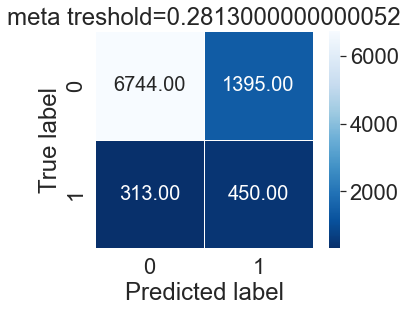

AUC 0.7091901088830587
F1 0.3450920245398773
Acc 0.8081330038193665
2.4870815547068075


In [74]:
# tresh=0.286
typ='meta'
for tresh in np.arange(0.1,0.5,0.0001):
    cost=12*sum(stacked_meta_val[typ]>tresh)/len(stacked_meta_val)
    if cost<2.5:
        break
print(f'Treshold: {tresh}')
confusion_matrix_graph(stacked_meta_val['y'], (stacked_meta_val[typ]>tresh).astype(int), f'{typ} treshold={tresh}')
scores(stacked_meta_val['y'], (stacked_meta_val[typ]>tresh))
print(12*sum(stacked_meta_val[typ]>tresh)/len(stacked_meta_val))


Treshold: 0.132


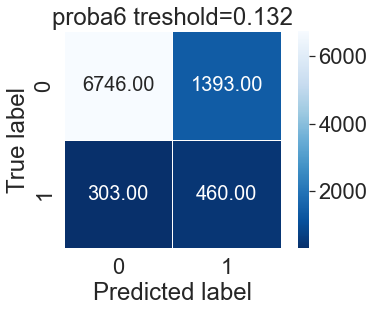

AUC 0.7158660540474909
F1 0.3516819571865444
Acc 0.8094810155021344
2.497865648168951


In [75]:
# tresh=0.145
typ='proba6'
for tresh in np.arange(0.001,0.5,0.001):
    cost=12*sum(stacked_meta_val[typ]>tresh)/len(stacked_meta_val)
    if cost<2.5:
        break
print(f'Treshold: {tresh}')
confusion_matrix_graph(stacked_meta_val['y'], (stacked_meta_val[typ]>tresh).astype(int), f'{typ} treshold={tresh}')
scores(stacked_meta_val['y'], (stacked_meta_val[typ]>tresh))
print(12*sum(stacked_meta_val[typ]>tresh)/len(stacked_meta_val))

# Final learn on all data

In [76]:
# learn the models on all data
stacked_data = TS_learning(X,y,typer,learn_models=True)


shape X (35772, 78)
shape y (35772,)
shape of X (35772, 78) shape of X_train (5962, 78) shape of X_test (5962, 78)
typ6 0
typ1 0
typ9 0
typ16 0
shape of X (35772, 78) shape of X_train (11924, 78) shape of X_test (5962, 78)
typ6 1
typ1 1
typ9 1
typ16 1
shape of X (35772, 78) shape of X_train (17886, 78) shape of X_test (5962, 78)
typ6 2
typ1 2
typ9 2
typ16 2
shape of X (35772, 78) shape of X_train (23848, 78) shape of X_test (5962, 78)
typ6 3
typ1 3
typ9 3
typ16 3
shape of X (35772, 78) shape of X_train (29810, 78) shape of X_test (5962, 78)
typ6 4
typ1 4
typ9 4
typ16 4


In [79]:

# meta_model=learn_meta_rf_model(stacked_data.drop(['y'], axis=1), stacked_data['y'])     

meta_model=learn_meta_ridge_model(stacked_data.drop(['y'], axis=1), stacked_data['y'],class_weight=None)    


8902
Treshold: 0.20800000000000002


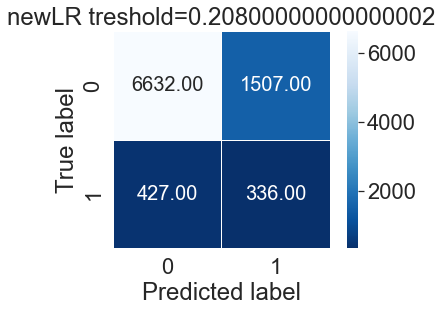

AUC 0.6276045453367014
F1 0.2578664620107444
Acc 0.7827454504605706
2.4843855313412715


In [82]:

from sklearn.linear_model import LogisticRegression
# apply logistic regression on the stacked data
logreg = LogisticRegression(solver='lbfgs',
                            class_weight='balanced',
                                multi_class='auto',
                                random_state=2022,
                                max_iter=1000)
new_model = logreg.fit(stacked_data.drop(['y'], axis=1), stacked_data['y'])

# print(stacked_meta_val.iloc[:,:-3]  )
pred = new_model.predict_proba(stacked_meta_val.iloc[:,:-3] )[:,1]
# pred = new_model.predict(stacked_meta_val.iloc[:,:-3] )

print(stacked_meta_val.shape[0])
for tresh in np.arange(0.001,0.5,0.001):
    cost=12*sum(pred>tresh)/len(stacked_meta_val)
    if cost<2.5:
        break
print(f'Treshold: {tresh}')
typ='newLR'
confusion_matrix_graph(stacked_meta_val['y'], pred>tresh, f'{typ} treshold={tresh}')
scores(stacked_meta_val['y'], pred>tresh)
# tresh=0
# confusion_matrix_graph(stacked_meta_val['y'], pred, f'{typ} treshold={tresh}')
# scores(stacked_meta_val['y'], pred)
print(12*sum(pred>tresh)/len(stacked_meta_val))
